In [107]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

with open("data/output.txt") as file:
    def process(line):
        d = json.loads(line)[1]
        sensor_measurement = d['sensor_measurement']
        measurement = d['sensor_measurement'].split(' ')
        d['sensor_type'] = measurement[0]
        if d['sensor_type'] == 'L':
            d['meas_x'] = float(measurement[1])
            d['meas_y'] = float(measurement[2])
        elif d['sensor_type'] == 'R':
            rho = float(measurement[1])
            phi = float(measurement[2])
            rho_dot = float(measurement[3])            
            d['meas_rho'] = rho
            d['meas_phi'] = phi
            d['meas_rhodot'] = rho_dot
            d['meas_x'] = rho * np.cos(phi)
            d['meas_y'] = rho * np.sin(phi)
        del d['sensor_measurement']
        return d
    
    data = [
        process(line) for line in file.readlines()
    ]
    

df = pd.DataFrame(data)
df.head()

,estimate_x,estimate_y,gt_vx,gt_vy,gt_x,gt_y,meas_phi,meas_rho,meas_rhodot,meas_x,meas_y,rmse_vx,rmse_vy,rmse_x,rmse_y,sensor_type
0,0.312243,0.580340,5.199937,0.000000,0.600000,0.600000,NaN,NaN,NaN,0.312243,0.580340,5.199937,0.000000,0.287757,0.019660,L
1,0.779913,0.722413,5.199747,0.001797,0.859997,0.600045,0.554329,1.014892,4.892807,0.862916,0.534212,3.817728,1.396498,0.211208,0.087637,R
2,1.195447,0.535063,5.199429,0.005390,1.119984,0.600225,NaN,NaN,NaN,1.173848,0.481073,4.294826,1.140272,0.177869,0.080843,L
3,1.032115,0.563929,5.198979,0.010778,1.379955,0.600629,0.389240,1.047505,4.511325,0.969149,0.397513,3.730942,1.628483,0.232328,0.072377,R
4,1.358774,0.703667,5.198392,0.017960,1.639904,0.601347,NaN,NaN,NaN,1.650626,0.624690,3.338551,1.754810,0.242874,0.079275,L


In [109]:
total_rows = df.shape[0]
bad_x_rows = len(df[df['rmse_x'] > 0.11].index)
bad_y_rows = len(df[df['rmse_y'] > 0.11].index)
bad_vx_rows = len(df[df['rmse_vx'] > 0.52].index)
bad_vy_rows = len(df[df['rmse_vy'] > 0.52].index)

print("Percentage of rows not meeting RMSE_x criterion: ", '{:.2f}'.format(bad_x_rows / total_rows * 100.), "%")
print("Percentage of rows not meeting RMSE_y criterion: ", '{:.2f}'.format(bad_y_rows / total_rows * 100.), "%")
print("Percentage of rows not meeting RMSE_vx criterion: ", '{:.2f}'.format(bad_vx_rows / total_rows * 100.), "%")
print("Percentage of rows not meeting RMSE_vy criterion: ", '{:.2f}'.format(bad_vy_rows / total_rows * 100.), "%")

print("Final RMSE_x value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_x']), ' < 0.11')
print("Final RMSE_y value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_y']), ' < 0.11')
print("Final RMSE_vx value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_vx']), ' < 0.52')
print("Final RMSE_vy value: ", '{:.3f}'.format(df.at[total_rows - 1 ,'rmse_vy']), ' < 0.52')

Percentage of rows not meeting RMSE_x criterion:  6.81 %
Percentage of rows not meeting RMSE_y criterion:  0.00 %
Percentage of rows not meeting RMSE_vx criterion:  67.54 %
Percentage of rows not meeting RMSE_vy criterion:  32.46 %
Final RMSE_x value:  0.097  < 0.11
Final RMSE_y value:  0.085  < 0.11
Final RMSE_vx value:  0.451  < 0.52
Final RMSE_vy value:  0.440  < 0.52


In [110]:
plt.style.use('seaborn-poster')
df_laser = df[df['sensor_type'] == 'L']
df_radar = df[df['sensor_type'] == 'R']

def createPlot():
    fig, ax = plt.subplots(figsize=(12, 8))

    plot_df.plot(kind='scatter', x='estimate_x', y='estimate_y', xerr='rmse_x', yerr='rmse_y', marker='^', s=2, color='green', ax=ax, label='Kalman Belief')
    plot_df.plot(kind='line', x='gt_x', y='gt_y', color='black', linewidth=0.5, ax=ax, label="Ground Truth")

    df_laser.plot(kind='scatter', x='meas_x', y='meas_y', marker='o', s=10, color='red', ax=ax, label='Laser Measurements')
    df_radar.plot(kind='scatter', x='meas_x', y='meas_y', marker='o', s=10, color='blue', ax=ax, label='Radar Measurements')
    
    return fig, ax

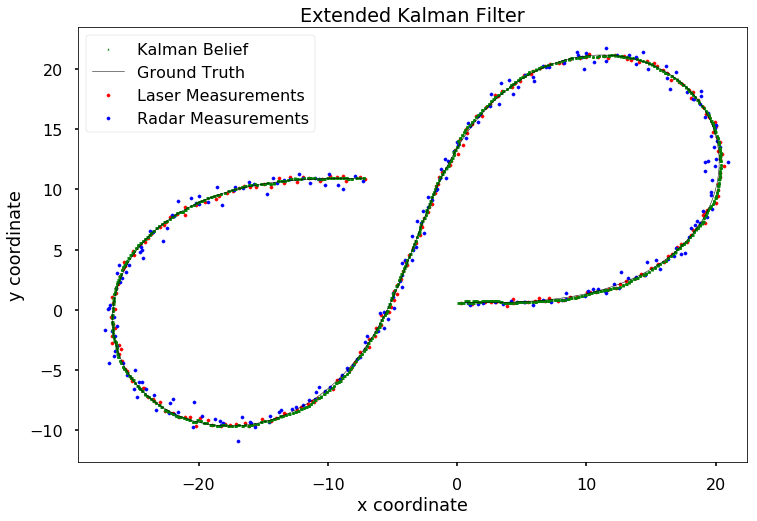

In [111]:
fig, ax = createPlot()
ax.set_xlim(1.1 * np.min(df['estimate_x']), 1.1 * np.max(df['estimate_x']))
ax.set(title='Extended Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig1.png')

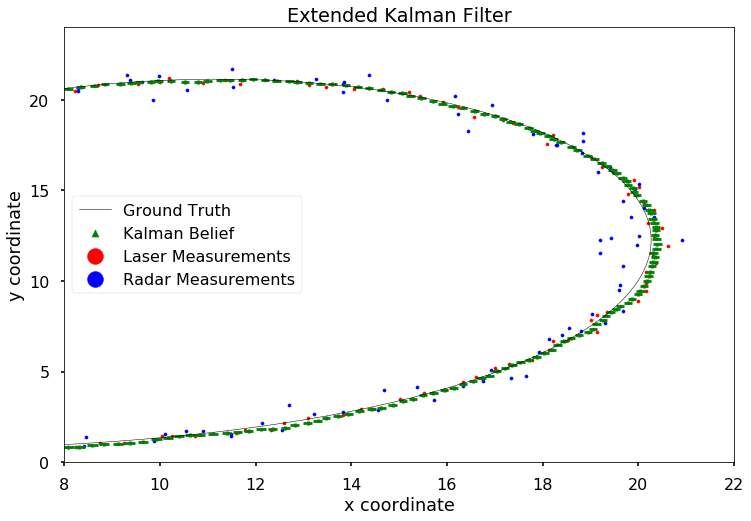

In [112]:
fig, ax = createPlot()
ax.set_xlim(8, 22)
ax.set_ylim(0, 24)
ax.legend(loc='center left', scatterpoints=1, markerscale=5)
ax.set(title='Extended Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig2.png')

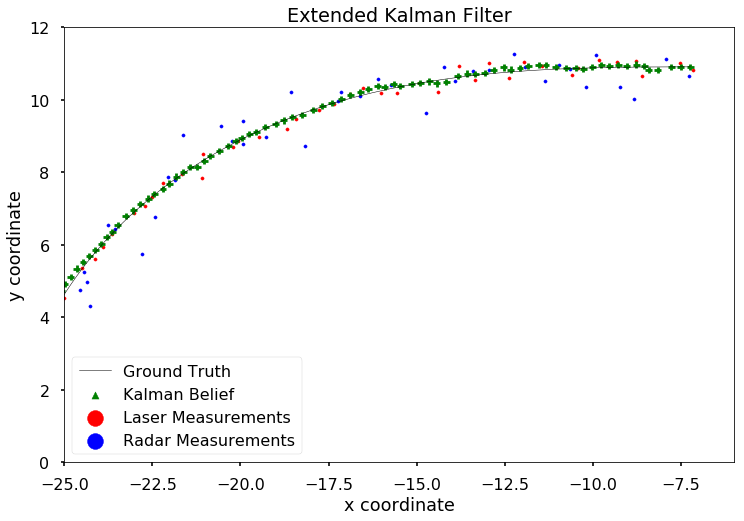

In [113]:
fig, ax = createPlot()
ax.set_xlim(-25, -6)
ax.set_ylim(0, 12)
ax.legend(loc='lower left', scatterpoints=1, markerscale=5)
ax.set(title='Extended Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig3.png')

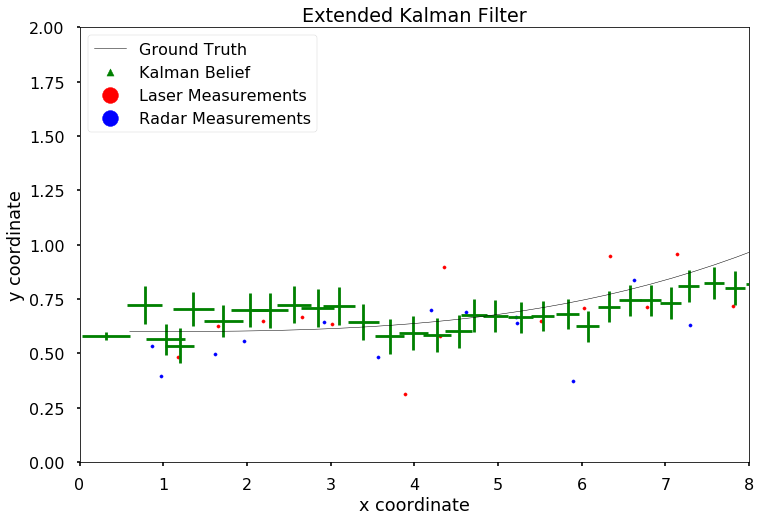

In [114]:
# First region, high error, linear path
fig, ax = createPlot()
ax.set_xlim(0, 8)
ax.set_ylim(0, 2)
ax.legend(loc='upper left', scatterpoints=1, markerscale=5)
ax.set(title='Extended Kalman Filter', xlabel='x coordinate', ylabel='y coordinate')
fig.savefig('results/fig4.png')